In [5]:
import pandas as pd
import os
import numpy as np
import collections
from Bio.Seq import Seq 
from Bio import pairwise2
from scipy.spatial import distance
from tqdm import tqdm

/home/mark/anaconda3/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [6]:
centromeres = pd.read_csv("/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/FinalCentromereLists/originals_wHiFiASM/hgsvc3_verkko_v1.4_hifiasm_v0.19.6_nonredundant_complete_and_accurate_centromeric_regions_v3.list",sep='\t',header=None)
chr2centromeres = centromeres[centromeres[2]=='chr20'].copy()

In [7]:
chr2centromeres['Start']=[int(x.split(":")[1].split("-")[0]) for x in chr2centromeres[1]]
chr2centromeres['End']=[int(x.split(":")[1].split("-")[1]) for x in chr2centromeres[1]]
chr2centromeres['Length']=[abs(int(chr2centromeres.at[x,'End'])-int(chr2centromeres.at[x,'Start'])) for x in chr2centromeres.index]

In [8]:
len(chr2centromeres)

42

In [9]:
centDF = pd.read_csv("/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/dataframes/goodMEI_HORCentromere_HIFIasmAndVerkko_wExtendedSequences_09-05-2024.csv").set_index("ID")
chr2 = centDF[centDF['CHROM']=='chr20'].copy()

In [12]:
uniqueChromosomes = set([x.split(":")[0]+"_"+str(centDF.at[x,'Sample'])+"_"+str(centDF.at[x,'Haplotype'])+"_"+str(centDF.at[x,'CHROM']) for x in centDF.index])
len(uniqueChromosomes)

383

In [13]:
cdrDF = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/FinalCentromereLists/chromosomes/hgsvc3_verkko_v1.4_hifiasm_v0.19.6_CDRs_chr20_v2_forMark.txt', sep='\t', header=None)
sampleCDRRegions = {sample:{'unassignedContig':'TEMP','unassigned':[],'haplotype1ContigHifi':'TEMP','haplotype1Hifi':[],'haplotype1Contig':'TEMP','haplotype1':[], 'haplotype2':[],'haplotype2Contig':'TEMP','haplotype2Hifi':[],'haplotype2ContigHifi':'TEMP'} for sample in set(cdrDF[0])}

for sample in set(cdrDF[0]):
    #print(sample)
    tempDF = cdrDF[cdrDF[0]==sample].copy()
    for row in tempDF.index:
        if 'h1tg' in tempDF.at[row,1]:
            sampleCDRRegions[sample]["haplotype1ContigHifi"]=str(tempDF.at[row,1])
            sampleCDRRegions[sample]["haplotype1Hifi"].append(str(tempDF.at[row,2])+"-"+str(tempDF.at[row,3]))
        elif 'h2tg' in tempDF.at[row,1]:
            sampleCDRRegions[sample]["haplotype2ContigHifi"]=str(tempDF.at[row,1])
            sampleCDRRegions[sample]["haplotype2Hifi"].append(str(tempDF.at[row,2])+"-"+str(tempDF.at[row,3]))
        else:
            sampleCDRRegions[sample][tempDF.at[row,1].split("-")[0]+"Contig"]=str(tempDF.at[row,1])
            sampleCDRRegions[sample][tempDF.at[row,1].split("-")[0]].append(str(tempDF.at[row,2])+"-"+str(tempDF.at[row,3]))

In [14]:
sampleCDRRegions['HG01457']

{'unassignedContig': 'TEMP',
 'unassigned': [],
 'haplotype1ContigHifi': 'h1tg000022l#1-66295033',
 'haplotype1Hifi': ['37475604-37490852',
  '37498716-37503560',
  '37741378-37743345',
  '37756764-37773402',
  '37781629-37790096',
  '37807781-37814577',
  '37865291-37883770',
  '37984184-37985292',
  '37989318-37999836'],
 'haplotype1Contig': 'haplotype1-0000010',
 'haplotype1': ['29600052-29611707',
  '29627515-29638540',
  '29663877-29664593',
  '29684857-29693216',
  '29699005-29712647',
  '29745176-29749539',
  '29759432-29764959',
  '29769712-29777663',
  '29783773-29794925',
  '29799969-29803847'],
 'haplotype2': [],
 'haplotype2Contig': 'TEMP',
 'haplotype2Hifi': [],
 'haplotype2ContigHifi': 'TEMP'}

In [15]:
from tqdm import tqdm 
for sample in tqdm(sampleCDRRegions.keys()):
    #print(sample)
    flag=0
    
    for haplotype in ['haplotype1','haplotype2','unassigned']:
        
        boundaries=[]
        for coordinate in sampleCDRRegions[sample][haplotype]:
            if len(boundaries)==0:
                boundaries.append(coordinate)
            else:
                for previousCoordinate in boundaries:
                    x = range(int(coordinate.split("-")[0]),int(coordinate.split("-")[1]))
                    y = range(int(previousCoordinate.split("-")[0]),int(previousCoordinate.split("-")[1]))
                    xs = set(x)
                    length = len(xs.intersection(y))
                    
                    
                    if length>0:
                        flag+=1
                    else:
                        continue
            
            boundaries.append(coordinate)

    if flag==0:
        continue
    else:
        print(sample)

100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 78.89it/s]


In [16]:
sampleCDRRegions['NA24385']

{'unassignedContig': 'TEMP',
 'unassigned': [],
 'haplotype1ContigHifi': 'TEMP',
 'haplotype1Hifi': [],
 'haplotype1Contig': 'haplotype1-0000013',
 'haplotype1': ['37241647-37249778',
  '37258928-37269854',
  '37302708-37308847',
  '37332230-37337661',
  '37341795-37351713',
  '37369191-37385368',
  '37392691-37407096',
  '37470639-37482740'],
 'haplotype2': ['39451277-39490728',
  '39524103-39534731',
  '39567407-39581275',
  '39596187-39605806'],
 'haplotype2Contig': 'haplotype2-0000075',
 'haplotype2Hifi': [],
 'haplotype2ContigHifi': 'TEMP'}

In [23]:
from Bio.Seq import Seq

#for element in set(chr2['TE_Designation']):
    tempDF = chr2[chr2['TE_Designation']==element].copy()
    #with open("/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/Chr20_Sequences/"+str(element.replace("/","_"))+".fasta", 'a+') as file:
        for row in tempDF.index:
            if tempDF.at[row,'Orientation'] =='+':
                file.write(">"+str(row)+"_"+str(tempDF.at[row,'Sample'])+"_"+str(tempDF.at[row,'Haplotype'])+"\n")
                file.write(str(tempDF.at[row,'Extended_Sequence'])+"\n")
                
            else:
                sequence = Seq(str(tempDF.at[row,'Extended_Sequence']))
                file.write(">"+str(row)+"_"+str(tempDF.at[row,'Sample'])+"_"+str(tempDF.at[row,'Haplotype'])+"\n")
                file.write(str(sequence.reverse_complement())+"\n")
    file.close()

## Read in the Unique Elements

In [17]:
from Bio import SeqIO

alu_v1_list = []
fasta_sequences = SeqIO.parse(open('/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/Chr20_Sequences/SINE_Alu_v1.fasta'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    print(name)
    alu_v1_list.append(name.split("_")[0])
    
L1_v1_list = []
fasta_sequences = SeqIO.parse(open('/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/Chr20_Sequences/LINE_L1_v1.fasta'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    L1_v1_list.append(name.split("_")[0])
    
L1_v2_list = []
fasta_sequences = SeqIO.parse(open('/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/Chr20_Sequences/LINE_L1_v2.fasta'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    L1_v2_list.append(name.split("_")[0])
    

haplotype1-0000010:27190081-27190358_HG01457_hap1


In [2]:
print(len(alu_v1_list)) #00d5ff
print(len(L1_v1_list)) #8cff00
print(len(L1_v2_list)) #ffb300

1
1
22


In [10]:
print(chr2.at[alu_v1_list[0],'Element_Annotation']) #light blue
print('\n')
print(chr2.at[L1_v1_list[0],'Element_Annotation']) #lime green
print(chr2.at[L1_v2_list[0],'Element_Annotation']) #orange

AluY


L1HS
L1HS


In [11]:
alu_v1_list

['haplotype1-0000010:27190081-27190358']

In [14]:
chr2centromeres

,0,1,2,3,Start,End,Length
6,HG00096,haplotype2-0000114:33641550-39773998,chr20,-,33641550,39773998,6132448
63,HG00358,haplotype1-0000005:33586012-40222660,chr20,-,33586012,40222660,6636648
77,HG00358,haplotype2-0000084:34110469-38543722,chr20,-,34110469,38543722,4433253
141,HG00731,haplotype1-0000025:33604246-39337702,chr20,-,33604246,39337702,5733456
147,HG00731,haplotype2-0000060:34213478-40644476,chr20,-,34213478,40644476,6430998
175,HG00733,haplotype1-0000018:33672669-39999067,chr20,-,33672669,39999067,6326398
187,HG00864,haplotype1-0000007:26226806-33719454,chr20,+,26226806,33719454,7492648
231,HG01352,haplotype1-0000018:26112868-32233166,chr20,+,26112868,32233166,6120298
244,HG01352,haplotype2-0000168:26098388-32321043,chr20,+,26098388,32321043,6222655
254,HG01457,h1tg000022l#1-66295033:34157195-40498593,chr20,-,34157195,40498593,6341398


In [16]:
chr2centromeres[chr2centromeres[1]=='haplotype1-0000010:27190081-27190358']

,0,1,2,3,Start,End,Length


In [6]:
21/24

0.875

In [14]:
chr2centromeres

,0,1,2,3,Start,End,Length
6,HG00096,haplotype2-0000114:33641550-39773998,chr20,-,33641550,39773998,6132448
63,HG00358,haplotype1-0000005:33586012-40222660,chr20,-,33586012,40222660,6636648
77,HG00358,haplotype2-0000084:34110469-38543722,chr20,-,34110469,38543722,4433253
141,HG00731,haplotype1-0000025:33604246-39337702,chr20,-,33604246,39337702,5733456
147,HG00731,haplotype2-0000060:34213478-40644476,chr20,-,34213478,40644476,6430998
175,HG00733,haplotype1-0000018:33672669-39999067,chr20,-,33672669,39999067,6326398
187,HG00864,haplotype1-0000007:26226806-33719454,chr20,+,26226806,33719454,7492648
231,HG01352,haplotype1-0000018:26112868-32233166,chr20,+,26112868,32233166,6120298
244,HG01352,haplotype2-0000168:26098388-32321043,chr20,+,26098388,32321043,6222655
254,HG01457,h1tg000022l#1-66295033:34157195-40498593,chr20,-,34157195,40498593,6341398


In [15]:
#Figure out the length of the HOR arrays
centroHORDF = pd.read_csv('/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/FinalCentromereLists/originals_wHiFiASM/hgsvc3_verkko_v1.4_hifiasm_v0.19.6_nonredundant_complete_and_accurate_active_asat_HOR_arrays_v3.list',sep='\t', header=None)
centroHORDF['Length']=[abs( int(x.split(":")[1].split("-")[1]) -int(x.split(":")[1].split("-")[0])) for x in centroHORDF[1]]
centroHORDF['Start']= [int(x.split(":")[1].split("-")[0]) for x in centroHORDF[1]]
centroHORDF['End']= [int(x.split(":")[1].split("-")[1]) for x in centroHORDF[1]]
centroHORDF['Haplotype']= [x.split(":")[0]+"_"+str(y) for x,y in zip(centroHORDF[1], centroHORDF[0])]
centroHORDF

,0,1,2,3,Length,Start,End,Haplotype
0,HG00096,h1tg000020l#1-134864016:50981805-54105816,chr11,+,3124011,50981805,54105816,h1tg000020l#1-134864016_HG00096
1,HG00096,h1tg000044l#1-4775385:271483-2484715,chr2,-,2213232,271483,2484715,h1tg000044l#1-4775385_HG00096
2,HG00096,h2tg000024l#1-133471904:99525684-101864402,chr8,-,2338718,99525684,101864402,h2tg000024l#1-133471904_HG00096
3,HG00096,haplotype1-0000003:88831344-90524600,chr14,-,1693256,88831344,90524600,haplotype1-0000003_HG00096
4,HG00096,haplotype1-0000033:23295101-23618710,chrY,-,323609,23295101,23618710,haplotype1-0000033_HG00096
...,...,...,...,...,...,...,...,...
1378,NA24385,haplotype2-0000087:96096375-97397180,chr13,-,1300805,96096375,97397180,haplotype2-0000087_NA24385
1379,NA24385,haplotype2-0000088:45060964-47417193,chr9,+,2356229,45060964,47417193,haplotype2-0000088_NA24385
1380,NA24385,haplotype2-0000091:11788435-13027486,chr15,+,1239051,11788435,13027486,haplotype2-0000091_NA24385
1381,NA24385,haplotype2-0000092:4714744-5420884,chr21,+,706140,4714744,5420884,haplotype2-0000092_NA24385


In [17]:
chr2['Color']='grey'
for row in chr2.index:
    if row.strip() in alu_v1_list:
        chr2.at[row,'Color']='#00d5ff'
        
    elif row.strip() in L1_v1_list:
        chr2.at[row,'Color']='#8cff00'
        
    elif row.strip() in L1_v2_list:
        chr2.at[row,'Color']='#ffb300'
    
    else:
        print(row)
        print("??")
chromtwoDF=chr2.copy()
chromtwoDF['Contig_Haplotype']=[x.split(":")[0]+"_"+str(y) for x,y in zip(chromtwoDF.index, chromtwoDF['Sample'])]

In [245]:
sampleCDRRegions

{'HG03371': {'unassignedContig': 'TEMP',
  'unassigned': [],
  'haplotype1ContigHifi': 'TEMP',
  'haplotype1Hifi': [],
  'haplotype1Contig': 'haplotype1-0000005',
  'haplotype1': ['93497869-93510747',
   '93514518-93534621',
   '93570913-93577104',
   '93621009-93637814',
   '93844761-93855089',
   '93862382-93871657'],
  'haplotype2': [],
  'haplotype2Contig': 'TEMP',
  'haplotype2Hifi': ['3182878-3199492',
   '3210092-3218398',
   '3242176-3252488',
   '3264244-3287738',
   '3324488-3353947',
   '3359096-3362384',
   '3368821-3388412',
   '3409292-3417728'],
  'haplotype2ContigHifi': 'h2tg000002l#1-152316002'},
 'NA18939': {'unassignedContig': 'unassigned-0001658',
  'unassigned': ['731326-770009',
   '783826-799575',
   '814165-822696',
   '944411-989340',
   '1001514-1006563'],
  'haplotype1ContigHifi': 'TEMP',
  'haplotype1Hifi': [],
  'haplotype1Contig': 'TEMP',
  'haplotype1': [],
  'haplotype2': [],
  'haplotype2Contig': 'TEMP',
  'haplotype2Hifi': [],
  'haplotype2ContigHifi':

In [18]:
chr2centromeres['Contig_Haplotype']=[x.split(":")[0]+"_"+str(y) for x,y in zip(chr2centromeres[1], chr2centromeres[0])]

In [19]:
chr2centromeres

,0,1,2,3,Start,End,Length,Contig_Haplotype
6,HG00096,haplotype2-0000114:33641550-39773998,chr20,-,33641550,39773998,6132448,haplotype2-0000114_HG00096
63,HG00358,haplotype1-0000005:33586012-40222660,chr20,-,33586012,40222660,6636648,haplotype1-0000005_HG00358
77,HG00358,haplotype2-0000084:34110469-38543722,chr20,-,34110469,38543722,4433253,haplotype2-0000084_HG00358
141,HG00731,haplotype1-0000025:33604246-39337702,chr20,-,33604246,39337702,5733456,haplotype1-0000025_HG00731
147,HG00731,haplotype2-0000060:34213478-40644476,chr20,-,34213478,40644476,6430998,haplotype2-0000060_HG00731
175,HG00733,haplotype1-0000018:33672669-39999067,chr20,-,33672669,39999067,6326398,haplotype1-0000018_HG00733
187,HG00864,haplotype1-0000007:26226806-33719454,chr20,+,26226806,33719454,7492648,haplotype1-0000007_HG00864
231,HG01352,haplotype1-0000018:26112868-32233166,chr20,+,26112868,32233166,6120298,haplotype1-0000018_HG01352
244,HG01352,haplotype2-0000168:26098388-32321043,chr20,+,26098388,32321043,6222655,haplotype2-0000168_HG01352
254,HG01457,h1tg000022l#1-66295033:34157195-40498593,chr20,-,34157195,40498593,6341398,h1tg000022l#1-66295033_HG01457


In [20]:
allHits=[]
chromosome='chr20'
for sampleContig in set(chr2centromeres['Contig_Haplotype']):
    
    #Length of the HOR Array (NOT CDR)
    chromosomeLengthDF = centroHORDF[(centroHORDF['Haplotype']==sampleContig) & (centroHORDF[2]==chromosome)].copy()
    arrayLength = int([x for x in chromosomeLengthDF['Length']][0])
    sample = str(sampleContig.split("_")[1])
    start = int([x for x in chromosomeLengthDF['Start']][0])
    end =int([x for x in chromosomeLengthDF['End']][0])
    Length =int([x for x in chromosomeLengthDF['Length']][0])
    
    #MEI Dataframe
    tempDF = chromtwoDF[chromtwoDF['Contig_Haplotype']==sampleContig].copy()
    
    #If you found mobile elements for the sample haplotype
    if len(tempDF)>0:
        
        #First lets deal with the CDRS
        if 'h1tg' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype1ContigHifi'
            cdrDict = sampleCDRRegions[sample]['haplotype1Hifi']
            additionalDesignatior='hifiasm'
            currentHap='hap1'
            
        elif 'h2tg' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype2ContigHifi'
            cdrDict = sampleCDRRegions[sample]['haplotype2Hifi']
            additionalDesignatior='hifiasm'
            currentHap='hap2'
            
        elif 'haplotype1' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype1Contig'
            cdrDict = sampleCDRRegions[sample]['haplotype1']
            additionalDesignatior='verkko'
            currentHap='hap1'
            
        elif 'haplotype2' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype2Contig'
            cdrDict = sampleCDRRegions[sample]['haplotype2']
            additionalDesignatior='verkko'
            currentHap='hap2'
        
        else:
            longCurrentHap = 'unassignedContig'
            cdrDict = sampleCDRRegions[sample]['unassigned']
            additionalDesignatior='verkko'
            currentHap='unassigned'
            
        for cdr in cdrDict:
            haplotypeContigName = sampleCDRRegions[sample][longCurrentHap]
            allHits.append([sample+"_"+str(currentHap)+"."+str(additionalDesignatior), int(cdr.split("-")[0])-int(start),int(cdr.split("-")[1])-int(start), 1, 'CDR', 'darkgrey', int(Length), sampleContig])

            
            
        #Now lets deal with the elements
        tempDF2 = tempDF.copy()
        for row in tempDF2.index:
            contig = str(row.split(":")[0])
            start2 =int(row.split(":")[1].split("-")[0])
            end2 =int(row.split(":")[1].split("-")[1])
            color = tempDF2.at[row,'Color']
            element = tempDF2.at[row,'Element_Annotation']
            
            allHits.append([sample+"_"+str(tempDF.at[row,'Haplotype']+"."+str(additionalDesignatior)), start2-int(start),end2-int(start), 1, element, color, int(Length), sampleContig])
        
        
    else:
        print(sample,sampleContig)
    
        #First lets deal with the CDRS
        if 'h1tg' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype1ContigHifi'
            cdrDict = sampleCDRRegions[sample]['haplotype1Hifi']
            additionalDesignatior='hifiasm'
            currentHap='hap1'
            
        elif 'h2tg' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype2ContigHifi'
            cdrDict = sampleCDRRegions[sample]['haplotype2Hifi']
            additionalDesignatior='hifiasm'
            currentHap='hap2'
            
        elif 'haplotype1' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype1Contig'
            cdrDict = sampleCDRRegions[sample]['haplotype1']
            additionalDesignatior='verkko'
            currentHap='hap1'
            
        elif 'haplotype2' in str(sampleContig.split("_")[0]):
            longCurrentHap = 'haplotype2Contig'
            cdrDict = sampleCDRRegions[sample]['haplotype2']
            additionalDesignatior='verkko'
            currentHap='hap2'
        
        else:
            longCurrentHap = 'unassignedContig'
            cdrDict = sampleCDRRegions[sample]['unassigned']
            additionalDesignatior='verkko'
            currentHap='unassigned'
            
        for cdr in cdrDict:
            haplotypeContigName = sampleCDRRegions[sample][longCurrentHap]
            allHits.append([sample+"_"+str(currentHap)+"."+str(additionalDesignatior), int(cdr.split("-")[0])-int(start),int(cdr.split("-")[1])-int(start), 1, 'CDR', 'darkgrey', int(Length), sampleContig])


NA19347 h1tg000008l#1-66109648_NA19347
HG01457 h1tg000022l#1-66295033_HG01457
NA20355 h2tg000005l#1-63915728_NA20355
HG01352 haplotype1-0000018_HG01352
NA19705 haplotype1-0000013_NA19705
HG02282 haplotype1-0000019_HG02282
HG02282 h2tg000097l#1-31476144_HG02282
HG03452 h1tg000028l#1-32699638_HG03452
HG03683 haplotype1-0000033_HG03683
HG00358 haplotype2-0000084_HG00358
HG00731 haplotype1-0000025_HG00731
HG03248 haplotype2-0000136_HG03248
HG03452 haplotype2-0000112_HG03452
HG03683 h1tg000034l#1-66575908_HG03683
HG00096 haplotype2-0000114_HG00096
HG00731 haplotype2-0000060_HG00731
HG01505 haplotype2-0000138_HG01505
NA24385 haplotype1-0000013_NA24385
HG01573 h1tg000030l#1-66728186_HG01573
HG02106 h1tg000014l#1-66429118_HG02106
HG01352 haplotype2-0000168_HG01352
HG01505 haplotype1-0000024_HG01505


In [21]:
allHitsDF = pd.DataFrame(data=allHits, columns=['Sample','Start','End','Count','Element','Color','ChromLength','Contig'])

In [22]:
allHitsDF.sort_values(by=['Sample','Start'])

,Sample,Start,End,Count,Element,Color,ChromLength,Contig
152,HG00096_hap2.verkko,85243,127047,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
153,HG00096_hap2.verkko,149469,161339,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
154,HG00096_hap2.verkko,201446,212354,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
155,HG00096_hap2.verkko,259840,279089,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
156,HG00096_hap2.verkko,319838,340692,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
...,...,...,...,...,...,...,...,...
143,NA24385_hap2.verkko,15740,17604,1,L1HS,#ffb300,2836229,haplotype2-0000075_NA24385
138,NA24385_hap2.verkko,2401726,2441177,1,CDR,darkgrey,2836229,haplotype2-0000075_NA24385
139,NA24385_hap2.verkko,2474552,2485180,1,CDR,darkgrey,2836229,haplotype2-0000075_NA24385
140,NA24385_hap2.verkko,2517856,2531724,1,CDR,darkgrey,2836229,haplotype2-0000075_NA24385


In [254]:
#allHits=[]
#for sample in set(chromtwoDF['Sample']):
    
    #All the HOR Arrays linked to this sample name
#    chromosome='chr2'
#    chromosomeLengthDF = centroHORDF[(centroHORDF[0]==sample) & (centroHORDF[2]==chromosome)].set_index('Haplotype')
    
    #All the MEIS linked to the sample name
#    tempDF = chromtwoDF[chromtwoDF['Sample']==sample].copy()
    
#    for haplotype in set(tempDF['Contig_Haplotype']):
#        hifiFlag=0
#        unassignedFlag=0
#        tempHapDF = tempDF[tempDF['Contig_Haplotype']==haplotype].copy()
        
#        if 'h1tg' in str(haplotype):
#            longCurrentHap = 'haplotype1ContigHifi'
#            cdrDict = sampleCDRRegions[sample]['haplotype1Hifi']
#            additionalDesignatior='hifiasm'
#            currentHap='hap1'
            
#        elif 'h2tg' in str(haplotype):
#            longCurrentHap = 'haplotype2ContigHifi'
#            cdrDict = sampleCDRRegions[sample]['haplotype2Hifi']
#            additionalDesignatior='hifiasm'
#            currentHap='hap2'
#            
#        elif 'haplotype1' in str(haplotype):
#            longCurrentHap = 'haplotype1Contig'
#            cdrDict = sampleCDRRegions[sample]['haplotype1']
#            additionalDesignatior='verkko'
#            currentHap='hap1'
#            
#        elif 'haplotype2' in str(haplotype):
#            longCurrentHap = 'haplotype2Contig'
#            cdrDict = sampleCDRRegions[sample]['haplotype2']
#            additionalDesignatior='verkko'
#            currentHap='hap2'
        
#        else:
#            longCurrentHap = 'unassignedContig'
#            cdrDict = sampleCDRRegions[sample]['unassigned']
#            additionalDesignatior='verkko'
#            currentHap='unassigned'
            
#        if len(cdrDict) == 0:
#            pass
        
#        else:
            
#            for cdr in cdrDict:
#                haplotypeContigName = sampleCDRRegions[sample][longCurrentHap]
#                allHits.append([sample+"_"+str(currentHap)+"."+str(additionalDesignatior), int(cdr.split("-")[0])-int(chromosomeLengthDF.at[haplotypeContigName,'Start']),int(cdr.split("-")[1])-int(chromosomeLengthDF.at[haplotypeContigName,'Start']), 1, 'CDR', 'darkgrey', int(chromosomeLengthDF.at[haplotypeContigName,'Length'])])

            
#        tempDF2 = tempDF[tempDF['Contig_Haplotype']==haplotype].copy()
        
        
        #tempList=[]
#        for row in tempDF2.index:
#            contig = str(row.split(":")[0])
#            start =int(row.split(":")[1].split("-")[0])
#            end =int(row.split(":")[1].split("-")[1])
#            color = tempDF2.at[row,'Color']
#            element = tempDF2.at[row,'Element_Annotation']
            
#            allHits.append([sample+"_"+str(tempDF.at[row,'Haplotype']+"."+str(additionalDesignatior)), start-int(chromosomeLengthDF.at[contig,'Start']),end-int(chromosomeLengthDF.at[contig,'Start']), 1, element, color, int(chromosomeLengthDF.at[contig,'Length'])])
        

In [24]:
#allHitsDF.to_csv("/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/allHitsDF_chr20.csv")

In [25]:
allHitsDF = pd.read_csv("/home/mark/Desktop/MEI_Group/HGSVC3/CentromereLocations/allHitsDF_chr20.csv").drop(columns=['Unnamed: 0'])

In [26]:
allHitsDF.sort_values(by=['Sample','Start'], inplace=True)

In [27]:
collections.Counter(allHitsDF['Color'])

Counter({'darkgrey': 224, '#ffb300': 22, '#00d5ff': 1, '#8cff00': 1})

In [31]:
len(chr2centromeres)

42

In [32]:
len(set(allHitsDF['Sample']))

42

In [33]:
allHitsDF

,Sample,Start,End,Count,Element,Color,ChromLength,Contig
152,HG00096_hap2.verkko,85243,127047,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
153,HG00096_hap2.verkko,149469,161339,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
154,HG00096_hap2.verkko,201446,212354,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
155,HG00096_hap2.verkko,259840,279089,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
156,HG00096_hap2.verkko,319838,340692,1,CDR,darkgrey,2829996,haplotype2-0000114_HG00096
...,...,...,...,...,...,...,...,...
143,NA24385_hap2.verkko,15740,17604,1,L1HS,#ffb300,2836229,haplotype2-0000075_NA24385
138,NA24385_hap2.verkko,2401726,2441177,1,CDR,darkgrey,2836229,haplotype2-0000075_NA24385
139,NA24385_hap2.verkko,2474552,2485180,1,CDR,darkgrey,2836229,haplotype2-0000075_NA24385
140,NA24385_hap2.verkko,2517856,2531724,1,CDR,darkgrey,2836229,haplotype2-0000075_NA24385


In [34]:
newList=[]
flipped=[]
for sample in set(allHitsDF['Sample']):
    currentPosition =1
    tempDF = allHitsDF[allHitsDF['Sample']==sample].copy()
    contig = str([x for x in tempDF['Contig']][0])
    orientation = [x for x in centroHORDF[centroHORDF['Haplotype']==contig][3]][0]
    if orientation == '+':
        flag=0
        for row in tempDF.index:
            if flag==0:
                newList.append([sample, 1, tempDF.at[row,'Start']-1, 0, 'lightgrey'])
                newList.append([sample, int(tempDF.at[row,'Start']), int(tempDF.at[row,'End']), 1, tempDF.at[row,'Color']])
                currentPosition = int(tempDF.at[row,'End'])+1
                flag=1
            else:
                newList.append([sample, currentPosition, tempDF.at[row,'Start']-1, 0, 'lightgrey'])
                newList.append([sample, int(tempDF.at[row,'Start']), int(tempDF.at[row,'End']), 1, tempDF.at[row,'Color']])
                currentPosition = int(tempDF.at[row,'End'])+1

        newList.append([sample, currentPosition, tempDF.at[row,'ChromLength'], 0, 'lightgrey'])
    else:
        flipped.append(sample)
        maxLength = max([int(x) for x in tempDF['ChromLength']])
        tempDF = tempDF.iloc[::-1].copy()
        tempDF['Start']=maxLength-tempDF['Start']
        tempDF['End']=maxLength-tempDF['End']
        flag=0
        for row in tempDF.index:
            if flag==0:
                newList.append([sample, 1, tempDF.at[row,'Start']-1, 0, 'lightgrey'])
                newList.append([sample, int(tempDF.at[row,'Start']), int(tempDF.at[row,'End']), 1, tempDF.at[row,'Color']])
                currentPosition = int(tempDF.at[row,'End'])+1
                flag=1
            else:
                newList.append([sample, currentPosition, tempDF.at[row,'Start']-1, 0, 'lightgrey'])
                newList.append([sample, int(tempDF.at[row,'Start']), int(tempDF.at[row,'End']), 1, tempDF.at[row,'Color']])
                currentPosition = int(tempDF.at[row,'End'])+1

        newList.append([sample, currentPosition, tempDF.at[row,'ChromLength'], 0, 'lightgrey'])


In [35]:
newListDF = pd.DataFrame(data=newList, columns=['CHROMOSOME','Start','End','Element','Color']).sort_values(by=['CHROMOSOME','Start'])

In [36]:
newListDF

,CHROMOSOME,Start,End,Element,Color
424,HG00096_hap2.verkko,1,2442780,0,lightgrey
426,HG00096_hap2.verkko,2402677,2473581,0,lightgrey
425,HG00096_hap2.verkko,2442781,2402676,1,darkgrey
428,HG00096_hap2.verkko,2464600,2510157,0,lightgrey
427,HG00096_hap2.verkko,2473582,2464599,1,darkgrey
...,...,...,...,...,...
464,NA24385_hap2.verkko,434503,395052,1,darkgrey
467,NA24385_hap2.verkko,2818626,2825092,0,lightgrey
466,NA24385_hap2.verkko,2820489,2818625,1,#ffb300
469,NA24385_hap2.verkko,2823230,2836229,0,lightgrey


In [34]:
# Convert 'CHROMOSOME' column to a categorical type with the custom order
newListDF['CHROMOSOME'] = pd.Categorical(newListDF['CHROMOSOME'], categories=reversed(qarmlist1), ordered=True)

# Sort the DataFrame by the 'samples' column
newListDF = newListDF.sort_values('CHROMOSOME')
#newListDF.dropna(inplace=True)

In [35]:
#longDict = {'hap1':'haplotype1', 'hap2':'haplotype2'}
#for chromosome in reversed(sorted(set(newListDF['CHROMOSOME']))):
#    tempDF = centroHORDF[(centroHORDF[0]==chromosome.split("_")[0]) & (centroHORDF[4]=='chr2')].copy()
    
#    for row in tempDF.index:
#        if longDict[chromosome.split("_")[1]] in tempDF.at[row,1]:
#            print(chromosome, tempDF.at[row,5])
#        else:
#            continue

In [37]:
newListDF.to_csv('/home/mark/Desktop/Test20.txt', sep='\t', index=None)

In [38]:
set(newListDF['Color'])

{'#00d5ff', '#8cff00', '#ffb300', 'darkgrey', 'lightgrey'}

In [ ]:
'#00d5ff': 1, '#8cff00'

In [43]:
newListDF[newListDF['Color']=='#00d5ff']

,CHROMOSOME,Start,End,Element,Color
130,HG01457_hap1.verkko,215642,215919,1,#00d5ff


In [46]:
allHitsDF[allHitsDF['Sample']=='HG01457_hap1.verkko']

,Sample,Start,End,Count,Element,Color,ChromLength,Contig
136,HG01457_hap1.verkko,215642,215919,1,AluY,#00d5ff,3093062,haplotype1-0000010_HG01457
126,HG01457_hap1.verkko,2625613,2637268,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
127,HG01457_hap1.verkko,2653076,2664101,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
128,HG01457_hap1.verkko,2689438,2690154,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
129,HG01457_hap1.verkko,2710418,2718777,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
130,HG01457_hap1.verkko,2724566,2738208,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
131,HG01457_hap1.verkko,2770737,2775100,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
132,HG01457_hap1.verkko,2784993,2790520,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
133,HG01457_hap1.verkko,2795273,2803224,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457
134,HG01457_hap1.verkko,2809334,2820486,1,CDR,darkgrey,3093062,haplotype1-0000010_HG01457


In [47]:
allHitsDF[allHitsDF['Sample']=='HG02587_hap2.verkko']

,Sample,Start,End,Count,Element,Color,ChromLength,Contig
172,HG02587_hap2.verkko,945543,963534,1,CDR,darkgrey,1408038,haplotype2-0000047_HG02587
173,HG02587_hap2.verkko,991556,1016921,1,CDR,darkgrey,1408038,haplotype2-0000047_HG02587
174,HG02587_hap2.verkko,1021640,1027025,1,CDR,darkgrey,1408038,haplotype2-0000047_HG02587
175,HG02587_hap2.verkko,1045438,1060592,1,CDR,darkgrey,1408038,haplotype2-0000047_HG02587
176,HG02587_hap2.verkko,1117082,1132361,1,CDR,darkgrey,1408038,haplotype2-0000047_HG02587
177,HG02587_hap2.verkko,1197701,1198641,1,L1HS,#8cff00,1408038,haplotype2-0000047_HG02587


In [42]:
newListDF[newListDF['Color']=='#8cff00']

,CHROMOSOME,Start,End,Element,Color
250,HG02587_hap2.verkko,1197701,1198641,1,#8cff00


/tmp/ipykernel_9904/1285249513.py:59: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  coll = BrokenBarHCollection(xranges, yrange, facecolors=colors)


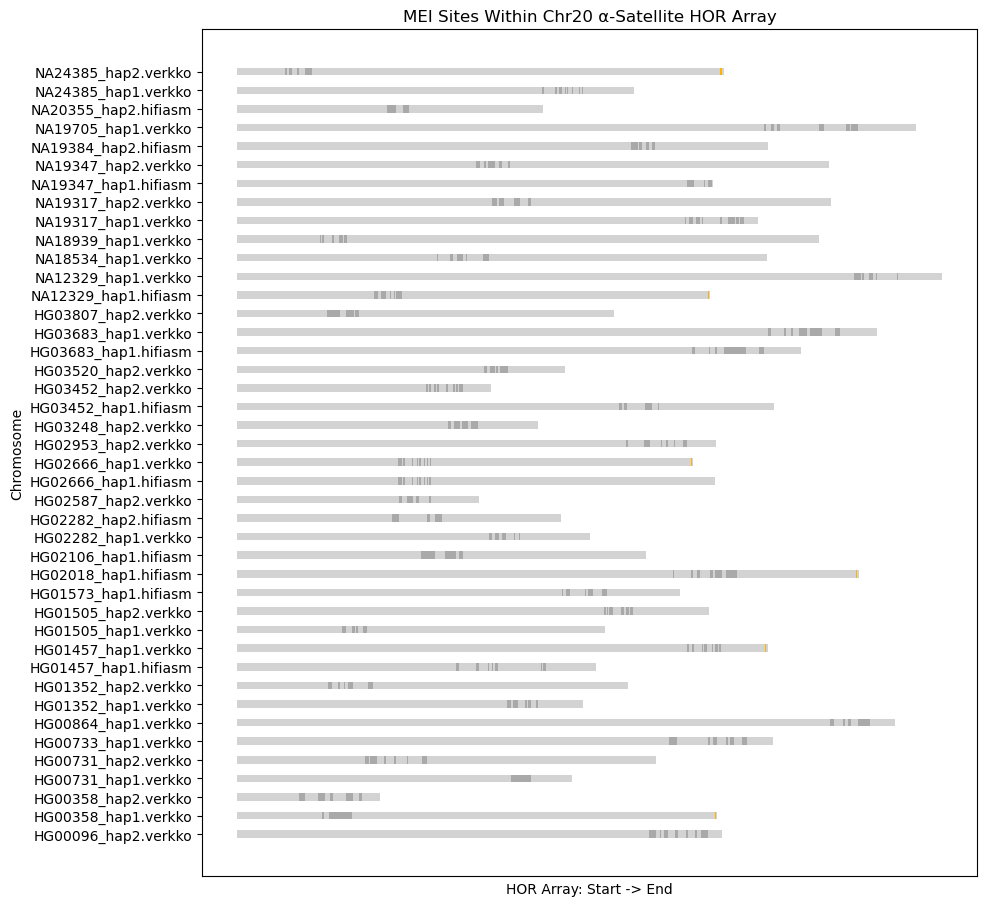

In [39]:
from matplotlib import pyplot as plt
from matplotlib.collections import BrokenBarHCollection
from matplotlib import rcParams
plt.rcParams.update(plt.rcParamsDefault)
rcParams['figure.figsize'] = 10,11

color_lookup = {'#00d5ff':'#00d5ff',
 '#1a0af7':'#1a0af7',
 '#8cff00':'#8cff00',
 '#E4003A':'#E4003A',
 '#bc0af7':'#bc0af7',
 'darkgrey':'darkgrey',
 '#ffb300':'#ffb300',
 'lightgrey':'lightgrey'}

height = 20.95
spacing = 30.95

def ideograms(fn):
    last_chrom = None
    fin = open(fn)
    fin.readline()
    xranges, colors = [], []
    ymin = 0

    for line in fin:
        chrom, start, stop, label, stain = line.strip().split('\t')

        start = int(start)
        stop = int(stop)
        width = stop - start
        if chrom == last_chrom or (last_chrom is None):
            xranges.append((start, width))
            colors.append(color_lookup[stain])
            last_chrom = chrom
            continue

        ymin += height + spacing
        yrange = (ymin, height)
        yield xranges, yrange, colors, last_chrom
        xranges, colors = [], []
        xranges.append((start, width))
        colors.append(color_lookup[stain])
        last_chrom = chrom

    # last one
    ymin += height + spacing
    yrange = (ymin, height)
    yield xranges, yrange, colors, last_chrom

fig = plt.figure()
ax = fig.add_subplot(111)
d = {}
yticks = []
yticklabels = []

# ideogram.txt downloaded from UCSC's table browser
for xranges, yrange, colors, label in ideograms('/home/mark/Desktop/Test20.txt'):
    coll = BrokenBarHCollection(xranges, yrange, facecolors=colors)
    #print(label)
    #print(colors)
    #print(xranges)
    ax.add_collection(coll)
    center = yrange[0] + yrange[1]/2.
    yticks.append(center)
    yticklabels.append(label)
    d[label] = xranges

ax.axis('tight')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xticks([])
plt.ylabel('Chromosome')
plt.xlabel('HOR Array: Start -> End')
plt.title("MEI Sites Within Chr20 α-Satellite HOR Array")  

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#legend_elements = [Line2D([0], [0], color='#C8C9C7', lw=2, label='0'),
#                   Line2D([0], [0], color='navy', lw=2, label='1'),
#                   Line2D([0], [0], color='#005EB8', lw=2, label='2'),
#                   Line2D([0], [0], color='green', lw=2, label='3'),
#                  ]
#ax.legend(handles=legend_elements, loc='upper right', title='Total SVAs')
plt.savefig('/home/mark/Desktop/chr20Alpha.svg', dpi=300, bbox_inches='tight')
#plt.savefig('/home/mark/Desktop/chr2Alpha.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
flipped

['HG02953_hap2.verkko',
 'NA19705_hap1.verkko',
 'HG02666_hap1.hifiasm',
 'HG03520_hap2.verkko',
 'NA24385_hap1.verkko',
 'HG00358_hap1.verkko',
 'HG00358_hap2.verkko',
 'NA18534_hap1.verkko',
 'HG00731_hap2.verkko',
 'HG02106_hap1.hifiasm',
 'HG03248_hap2.verkko',
 'HG00731_hap1.verkko',
 'HG01457_hap1.hifiasm',
 'NA19317_hap1.verkko',
 'HG03683_hap1.verkko',
 'HG00096_hap2.verkko',
 'NA19317_hap2.verkko',
 'NA24385_hap2.verkko',
 'HG00733_hap1.verkko',
 'HG02018_hap1.hifiasm',
 'NA19347_hap1.hifiasm',
 'HG03683_hap1.hifiasm']